In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import os
import numpy as np
from functools import reduce
project_root_dir = '/content/drive/My Drive/CS_229_project/aqi_data/'

Build the files from scratch

In [3]:
aqi_classes = ['Good', 'Moderate', 'Unhealthy for sensitive groups', 'Unhealthy', 'Very unhealthy', 'Hazardous']
aqi_cutoffs = np.array([0, 50, 100, 150, 200, 300, np.inf])
year_list = [2016, 2017, 2018, 2019, 2020]

In [ ]:
def load_data_in_year_range(base_file, file_type, year_range):
  file_list = []
  for year in year_range:
    file_list.append(pd.read_csv(base_file + '_' + file_type + '_' + str(year) + '.csv'))
  
  final_file = reduce(lambda x, y: pd.concat([x, y], ignore_index = True), file_list)
  final_file = final_file[["Date", "Site ID", "DAILY_AQI_VALUE"]]
  renamed_column = file_type + '_AQI'
  final_file = final_file.rename(columns = {'Date': 'Date', 'Site ID': 'Site_ID','DAILY_AQI_VALUE': renamed_column})
  final_file['Date'] = pd.to_datetime(final_file['Date'])
  return final_file

In [ ]:
def clean_AQI_csv(aqi_classes, aqi_cutoffs, year_list):
  base_file = os.path.join(project_root_dir, 'all_sites')

  ozone_data = load_data_in_year_range(base_file, 'ozone', year_list)
  pm_data = load_data_in_year_range(base_file, 'pm2.5', year_list)

  site = pd.merge(ozone_data, pm_data, how = 'outer', on = ['Date', 'Site_ID'])
  site = site.fillna(0)
  site = site[~((site["ozone_AQI"] == 0) & (site["pm2.5_AQI"] == 0))]
  site['AQI'] = np.array([np.max(aqi_types) for aqi_types in site.loc[:, ['ozone_AQI', 'pm2.5_AQI']].to_numpy()])

  site['class'] = pd.cut(site['AQI'], bins = aqi_cutoffs, labels = np.arange(6))
  site['pm2.5_class'] = pd.cut(site['pm2.5_AQI'], bins = aqi_cutoffs, labels = np.arange(6))
  site['AQI_class'] = pd.cut(site['AQI'], bins = aqi_cutoffs, labels = aqi_classes)
  site['pm2.5_AQI_class'] = pd.cut(site['pm2.5_AQI'], bins = aqi_cutoffs, labels = aqi_classes)
  site = site.sort_values(['Date', 'Site_ID'])
  site = site[(site[('Date')] <= '2020-10-11')]
  site = site[~site[["Date", "Site_ID"]].duplicated()]
  site.to_csv(os.path.join(project_root_dir, 'final_data', 'all_sites_data.csv'), index = False)

In [ ]:
clean_AQI_csv(aqi_classes, aqi_cutoffs, year_list)

## PM 2.5 Only

In [4]:
all_sites_data = pd.read_csv(os.path.join(project_root_dir, 'final_data', 'all_sites_data.csv'))

In [6]:
df = all_sites_data.dropna()

In [7]:
all_sites_data

,Date,Site_ID,ozone_AQI,pm2.5_AQI,AQI,class,pm2.5_class,AQI_class,pm2.5_AQI_class
0,2016-01-01,60010007,29.0,41.0,41.0,0,0.0,Good,Good
1,2016-01-01,60010009,29.0,13.0,29.0,0,0.0,Good,Good
2,2016-01-01,60010011,28.0,25.0,28.0,0,0.0,Good,Good
3,2016-01-01,60010012,0.0,17.0,17.0,0,0.0,Good,Good
4,2016-01-01,60012005,27.0,0.0,27.0,0,NaN,Good,NaN
...,...,...,...,...,...,...,...,...,...
339004,2020-10-11,61111004,40.0,32.0,40.0,0,0.0,Good,Good
339005,2020-10-11,61112002,49.0,45.0,49.0,0,0.0,Good,Good
339006,2020-10-11,61113001,35.0,31.0,35.0,0,0.0,Good,Good
339007,2020-10-11,61130004,35.0,30.0,35.0,0,0.0,Good,Good


In [8]:
np.sum(df['AQI_class'] != df['pm2.5_AQI_class']) / df.shape[0]

0.10553494434974431

In [9]:
df['pm2.5_class'] = df['pm2.5_class'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
df[df['AQI_class'] != df['pm2.5_AQI_class']]

,Date,Site_ID,ozone_AQI,pm2.5_AQI,AQI,class,pm2.5_class,AQI_class,pm2.5_AQI_class
7835,2016-02-11,60650016,64.0,11.0,64.0,1,0,Moderate,Good
7869,2016-02-11,60731006,58.0,14.0,58.0,1,0,Moderate,Good
7994,2016-02-12,60371201,80.0,40.0,80.0,1,0,Moderate,Good
8027,2016-02-12,60592022,105.0,33.0,105.0,2,0,Unhealthy for sensitive groups,Good
8037,2016-02-12,60650009,61.0,40.0,61.0,1,0,Moderate,Good
...,...,...,...,...,...,...,...,...,...
338314,2020-10-07,61112002,105.0,62.0,105.0,2,1,Unhealthy for sensitive groups,Moderate
338354,2020-10-08,60290019,119.0,93.0,119.0,2,1,Unhealthy for sensitive groups,Moderate
338571,2020-10-09,60650010,105.0,58.0,105.0,2,1,Unhealthy for sensitive groups,Moderate
338574,2020-10-09,60652002,105.0,89.0,105.0,2,1,Unhealthy for sensitive groups,Moderate


In [ ]:
df.iloc[np.argmax(df['class'] - df['pm2.5_class'])]

Date                   2016-06-28
Site_ID                  60710005
ozone_AQI                     203
pm2.5_AQI                      48
AQI                           203
class                           4
pm2.5_class                     0
AQI_class          Very unhealthy
pm2.5_AQI_class              Good
Name: 35073, dtype: object

In [ ]:
import collections

normal_AQI = collections.Counter(df['AQI_class']).values()

In [ ]:
pm_AQI = collections.Counter(df['pm2.5_AQI_class']).values()

In [ ]:
df2 = pd.DataFrame({'max_AQI': normal_AQI, 'pm2.5_AQI': pm_AQI})

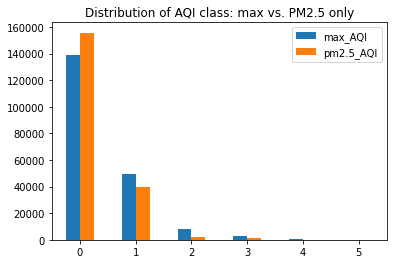

In [ ]:
ax = df2.plot.bar(rot = 0, title = "Distribution of AQI class: max vs. PM2.5 only")
fig = ax.get_figure()
fig.savefig(os.path.join(project_root_dir, 'max_vs_pm2.5_dist_all.png'))

In [ ]:
df['class_diff'] = df['class'] - df['pm2.5_class']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
class_diff = collections.Counter(df['class_diff'])
df3 = pd.DataFrame({'class_diff': class_diff})

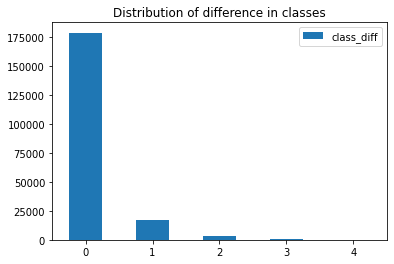

In [ ]:
ax = df3.plot.bar(rot = 0, title = 'Distribution of difference in classes')
fig = ax.get_figure()
fig.savefig(os.path.join(project_root_dir, 'class_diffs_max_vs_pm2.5_all.png'))

In [11]:
df

,Date,Site_ID,ozone_AQI,pm2.5_AQI,AQI,class,pm2.5_class,AQI_class,pm2.5_AQI_class
0,2016-01-01,60010007,29.0,41.0,41.0,0,0,Good,Good
1,2016-01-01,60010009,29.0,13.0,29.0,0,0,Good,Good
2,2016-01-01,60010011,28.0,25.0,28.0,0,0,Good,Good
3,2016-01-01,60010012,0.0,17.0,17.0,0,0,Good,Good
7,2016-01-01,60070008,28.0,60.0,60.0,1,1,Moderate,Moderate
...,...,...,...,...,...,...,...,...,...
339003,2020-10-11,61110009,44.0,52.0,52.0,1,1,Moderate,Moderate
339004,2020-10-11,61111004,40.0,32.0,40.0,0,0,Good,Good
339005,2020-10-11,61112002,49.0,45.0,49.0,0,0,Good,Good
339006,2020-10-11,61113001,35.0,31.0,35.0,0,0,Good,Good


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff506790ac8>]],
      dtype=object)

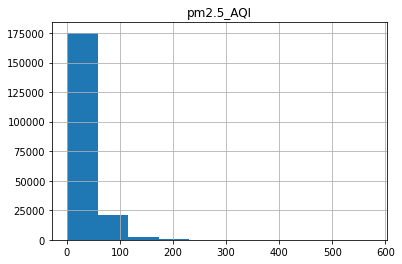

In [13]:
df.hist(column = 'pm2.5_AQI')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5062f9358>,
      dtype=object)

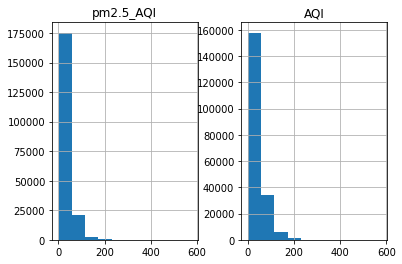

In [14]:
df.hist(column = ['pm2.5_AQI', 'AQI'])

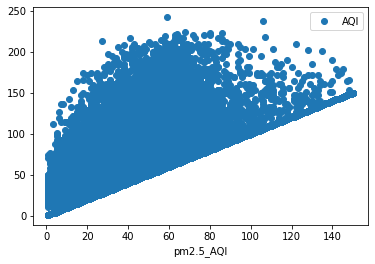

In [18]:
df[df['pm2.5_AQI'] <= 150].plot(x = 'pm2.5_AQI', y = 'AQI', style = 'o')

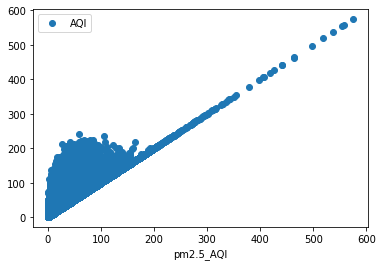

In [21]:
df.plot(x = 'pm2.5_AQI', y = 'AQI', style = 'o')

In [22]:
df[['pm2.5_AQI', 'AQI']].corr()

,pm2.5_AQI,AQI
pm2.5_AQI,1.000000,0.770061
AQI,0.770061,1.000000
